In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates

# Data Import and Cleaning 

In [40]:
#shared_dir_path = os.environ["SHARED_DATA_DIR"] + '/'
shared_dir_path = '' # sub this out for above comment when using in notable
path = shared_dir_path + 'ESDA2_GroupProject_Data/'

In [41]:
# read glacier data
file = 'glacier_area.xlsx'
file_path = path + file
glacier_area = pd.read_excel(file_path)

In [42]:
# make a dict of each glacier location
glacier_locations = glacier_area[['Glacier', 'Latitude', 'Longitude']].set_index('Glacier').T
glacier_locations = glacier_locations.rename(index={'Latitude': 'lat', 'Longitude': 'lon'})
glacier_locations = glacier_locations.to_dict()

In [43]:
# drop lat/lon data and convert to timeseries index
glacier_timeseries = glacier_area.drop(['Latitude', 'Longitude'], axis=1).set_index('Glacier').T
glacier_timeseries.index = pd.to_datetime(glacier_timeseries.index)

In [44]:
# read station metdata
file = '420800.csv'
file_path = path + file
station_420800 = pd.read_csv(file_path, delimiter=';')

file = '422100.csv'
file_path = path + file
station_422100 = pd.read_csv(file_path, delimiter=';')

file = '425000.csv'
file_path = path + file
station_425000 = pd.read_csv(file_path, delimiter=';')

file = '430100.csv'
file_path = path + file
station_430100 = pd.read_csv(file_path, delimiter=';')

file = '432000.csv'
file_path = path + file
station_432000 = pd.read_csv(file_path, delimiter=';')

file = '436000.csv'
file_path = path + file
station_436000 = pd.read_csv(file_path, delimiter=';')

file = 'station_details.xlsx'
file_path = path + file
station_details = pd.read_excel(file_path)

In [45]:
# clean station data to be airtemp timeseries
metdata_420800 = station_420800.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_420800['Date'] = pd.to_datetime(metdata_420800[['Year', 'Month', 'Day', 'Hour']])
metdata_420800 = metdata_420800.set_index('Date')
metdata_420800 = metdata_420800[['airtemp']]

metdata_422100 = station_422100.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_422100['Date'] = pd.to_datetime(metdata_422100[['Year', 'Month', 'Day', 'Hour']])
metdata_422100 = metdata_422100.set_index('Date')
metdata_422100 = metdata_422100[['airtemp']]

metdata_425000 = station_425000.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_425000['Date'] = pd.to_datetime(metdata_425000[['Year', 'Month', 'Day', 'Hour']])
metdata_425000 = metdata_425000.set_index('Date')
metdata_425000 = metdata_425000[['airtemp']]

metdata_430100 = station_430100.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_430100['Date'] = pd.to_datetime(metdata_430100[['Year', 'Month', 'Day', 'Hour']])
metdata_430100 = metdata_430100.set_index('Date')
metdata_430100 = metdata_430100[['airtemp']]

metdata_432000 = station_432000.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_432000['Date'] = pd.to_datetime(metdata_432000[['Year', 'Month', 'Day', 'Hour']])
metdata_432000 = metdata_432000.set_index('Date')
metdata_432000 = metdata_432000[['airtemp']]

metdata_436000 = station_436000.rename(columns={'Hour(utc)': 'Hour', '101':'airtemp'})
metdata_436000['Date'] = pd.to_datetime(metdata_436000[['Year', 'Month', 'Day', 'Hour']])
metdata_436000 = metdata_436000.set_index('Date')
metdata_436000 = metdata_436000[['airtemp']]

# set a dict to make each station accessible later
metdata = {
    '420800': metdata_420800,
    '422100': metdata_422100,
    '425000': metdata_425000,
    '430100': metdata_430100,
    '432000': metdata_432000,
    '436000': metdata_436000
}

In [46]:
# read sst netCDF file
file = 'HadISST_SST_northatlantic.nc'
file_path = path + file
ds = nc.Dataset(file_path)

# isolate variables
sst_timedelta = ds.variables['time'][:]
sst_lat = ds.variables['latitude'][:]
sst_lon = ds.variables['longitude'][:]
sst = ds.variables['sst'][:,:,:]

In [47]:
# convert time from start to a date
sst_time = pd.to_timedelta(sst_timedelta, unit='D') + pd.Timestamp('1870-01-01 00:00:00')

In [48]:
# map below freezing values to frozen value (1.8)
mask_value = -1.8
freezing_point = -1.8
sst[sst < mask_value] = freezing_point

# Functions

In [49]:
# pick what SST values corresponds to chosen glacier
def pick_closest_SST(lats, lons, sst, glacier):
    """
    lats: 1D array of latitudes
    lons: 1D array of longitudes
    sst: 3D array of sea surface temp at (time, latitude, longitude)
    glacier: (lat, lon); a tuple of glacier coordinates

    returns: ind_lat, ind_lon -> indices to get sst data closest to glacier
    """
    sst_slice = sst[-1, :, :]   # last time step
    mask = sst_slice.mask
    
    lon2d, lat2d = np.meshgrid(lons, lats)
    
    dist = np.sqrt((lat2d - glacier[0])**2 + (lon2d - glacier[1])**2)

    dist_masked = np.ma.array(dist, mask=mask)

    pair = np.unravel_index(np.argmin(dist_masked), dist_masked.shape)

    ind_lat = pair[0]
    ind_lon = pair[1]
    
    return ind_lat, ind_lon

In [50]:
# find closest station (airtemp) for chosen glacier
def pick_closest_airtemp(station_details, glacier_location):
    """
    station_details: dataframe with columns 'Station Code', 'Latitude', 'Longitude'
    target_lat: latitude of glacier
    target_lon: longitude of glacier

    returns: station_code -> code of closest station
    """
    target_lat, target_lon = glacier_location
    lats = station_details['Latitude'].values
    lons = station_details['Longitude'].values
    station_codes = station_details['Station number'].values

    dist = np.sqrt((lats - target_lat)**2 + (lons - target_lon)**2)

    min_index = np.argmin(dist)

    station_number = station_codes[min_index]

    return station_number   

In [51]:
# create df of robust yearly averaged values (inner join) for chosen glacier
def get_glacier_df(GLACIER, SAMPLE_TIME):

    target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])

    # get data from closest met station
    station_number = pick_closest_airtemp(station_details, target_location)
    glacier_metdata = metdata[str(station_number)]

    # take only year where we have data for all months - avoids bias from missing months, as temp varies seasonally
    glacier_metdata = glacier_metdata[~glacier_metdata['airtemp'].isna()]
    months_per_year = glacier_metdata.groupby(glacier_metdata.index.year).apply(lambda x: x.index.month.nunique())
    valid_years = months_per_year[months_per_year == 12].index
    glacier_metdata = glacier_metdata[glacier_metdata.index.year.isin(valid_years)]

    # get SST data from closest grid point and convert to time series
    ind_lat, ind_lon = pick_closest_SST(sst_lat, sst_lon, sst, target_location)
    glacier_sst = sst[:, ind_lat, ind_lon]
    glacier_sst = pd.DataFrame({'Date': sst_time, 'SST': glacier_sst})
    glacier_sst = glacier_sst.set_index('Date')

    # align time series to common start date
    start = max(glacier_timeseries.index[0], glacier_metdata.index[0], glacier_sst.index[0])

    glacier_area_series = glacier_timeseries[GLACIER][glacier_timeseries.index >= start]
    glacier_metdata_series = glacier_metdata[glacier_metdata.index >= start]
    glacier_sst_series = glacier_sst[glacier_sst.index >= start]

    # resample time series
    glacier_area_resampled = glacier_area_series.resample(SAMPLE_TIME).mean().dropna()
    glacier_metdata_resampled = glacier_metdata_series.resample(SAMPLE_TIME).mean().dropna()
    glacier_sst_resampled = glacier_sst_series.resample(SAMPLE_TIME).mean().dropna()

    # join time series into single dataframe
    glacier_df = pd.concat([glacier_area_resampled, glacier_metdata_resampled, glacier_sst_resampled], axis=1, join='inner')
    glacier_df = glacier_df.rename(columns={GLACIER: 'area'})
    
    return glacier_df

In [52]:
# bootstrap function for linear regression (from datacamp)
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds)) # selected with replacement - omits random data points per sample
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

# Question 1

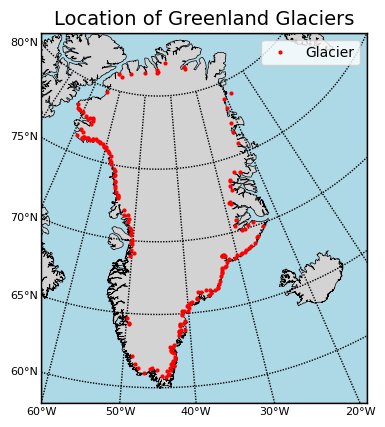

In [53]:
# create and plot map of glacier locations
m = Basemap(
    projection='lcc',  # Lambert Conformal Conic
    lat_0=70,          # Center latitude
    lon_0=-45,         # Center longitude
    lat_1=60,          # First standard parallel
    lat_2=80,          # Second standard parallel
    llcrnrlat=58,      # Lower left corner latitude
    urcrnrlat=75,      # Upper right corner latitude
    llcrnrlon=-60,     # Lower left corner longitude
    urcrnrlon=25,     # Upper right corner longitude
    resolution='i',    # Intermediate resolution
    area_thresh=1000   # Minimum area for coastlines
)

# Draw map features
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=1)
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Add gridlines
m.drawmeridians(range(-80, 0, 10), labels=[0,0,0,1], fontsize=8)
m.drawparallels(range(60, 85, 5), labels=[1,0,0,0], fontsize=8)

# get xy coordinated of glaciers from lat/lon
lons = [glacier_locations[key]['lon'] for key in glacier_locations]
lats = [glacier_locations[key]['lat'] for key in glacier_locations]
x, y = m(lons, lats)

# Plot the point locaitons
m.plot(x, y, 'ro', markersize=2, label='Glacier')

# customise plot
plt.title('Location of Greenland Glaciers', fontsize=14)
plt.legend(bbox_to_anchor=(1,1), loc='upper right')
plt.show()

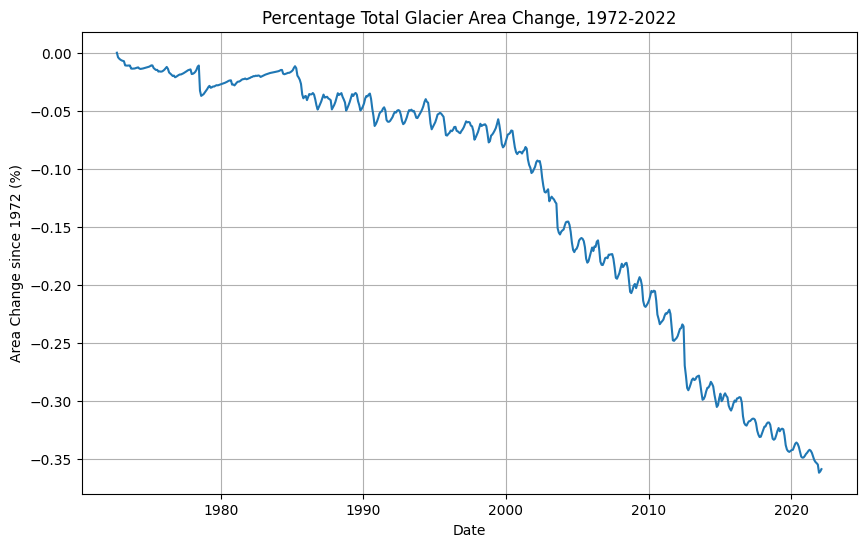

In [54]:
# timersiers plot of total area % change in glacier area
# calculate percentage loss
sum_areas = glacier_timeseries.sum(axis=1)
pct_loss = (sum_areas - sum_areas.iloc[0]) / sum_areas.iloc[0] * 100 # percentage

# plot percentage loss
plt.figure(figsize=(10,6))
plt.plot(pct_loss.index, pct_loss)
plt.xlabel('Date')
plt.ylabel('Area Change since 1972 (%)')
plt.title('Percentage Total Glacier Area Change, 1972-2022')
plt.grid()
plt.show()

In [55]:
# what does 0.1% correlate to
print(f"{sum_areas.iloc[0]*0.1/100:.2f}km^2")

1317.42km^2


In [56]:
# how much total area lost 1972-2022
print(f"{sum_areas.iloc[0] - sum_areas.iloc[-1]:.2f}km^2")

4725.17km^2


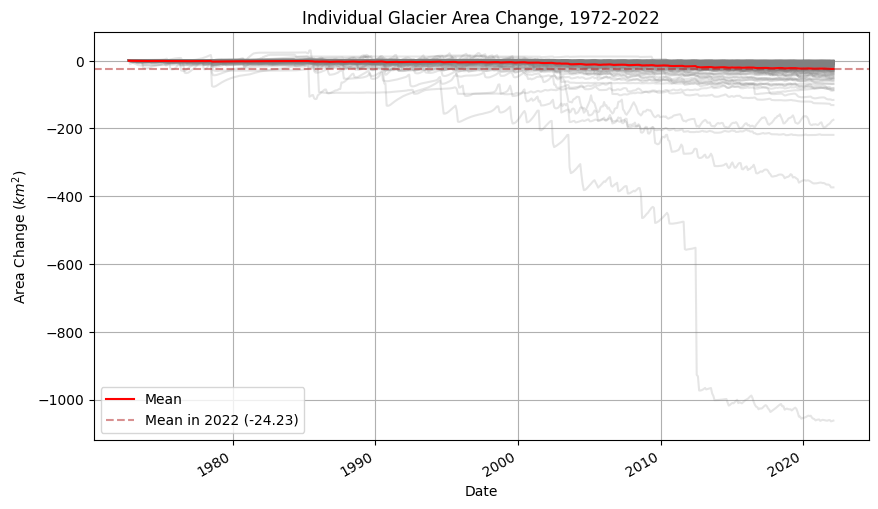

In [57]:
# area change and change in mean of all glaciers
# calculate change in area
delta_df = glacier_timeseries - glacier_timeseries.iloc[0]

# set figure and axis
fig, ax = plt.subplots(1,1, figsize=(10,6))

# plot timeseires for all glaciers as 'background'
for glacier in delta_df:
    delta_df[glacier].plot(ax=ax, color='grey', alpha=0.2, label='_nolegend_')

#plot mean and mean in 2022 
delta_df.mean(axis=1).plot(ax=ax, color='red', label='Mean')
mean_2022 = delta_df.mean(axis=1).iloc[-1]
plt.axhline(mean_2022, linestyle='--', color='firebrick', alpha=0.5, label=f'Mean in 2022 ({mean_2022:.2f})')

# customise plot
plt.xlabel('Date')
plt.ylabel(r'Area Change ($km^2$)')
plt.title('Individual Glacier Area Change, 1972-2022')
plt.legend()
plt.grid()
plt.show()


# Question 2

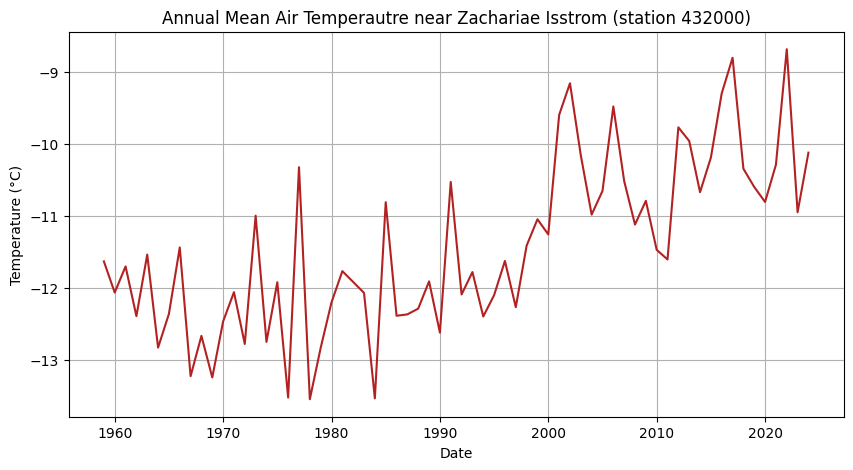

In [58]:
# annual mean airtemp close to glacier of choice
# choose glacier
GLACIER = 'Zachariae Isstrom'

# find closest station
target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])
station_number = pick_closest_airtemp(station_details, target_location)
airtemp_data = metdata[str(station_number)]

# get robust yearly averages (full yearly data)
airtemp_data_r = airtemp_data[~airtemp_data['airtemp'].isna()]
mpy = airtemp_data_r.groupby(airtemp_data_r.index.year).apply(lambda x: x.index.month.nunique())
vy = mpy[mpy == 12].index
airtemp_data_r = airtemp_data_r[airtemp_data_r.index.year.isin(vy)]

yearly_airtemp = airtemp_data_r.resample('YE').mean().dropna()


# plot and customise graph
plt.figure(figsize=(10,5))
plt.plot(yearly_airtemp, color='firebrick')
plt.title(f'Annual Mean Air Temperautre near {GLACIER} (station {station_number})')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.grid()
plt.show()

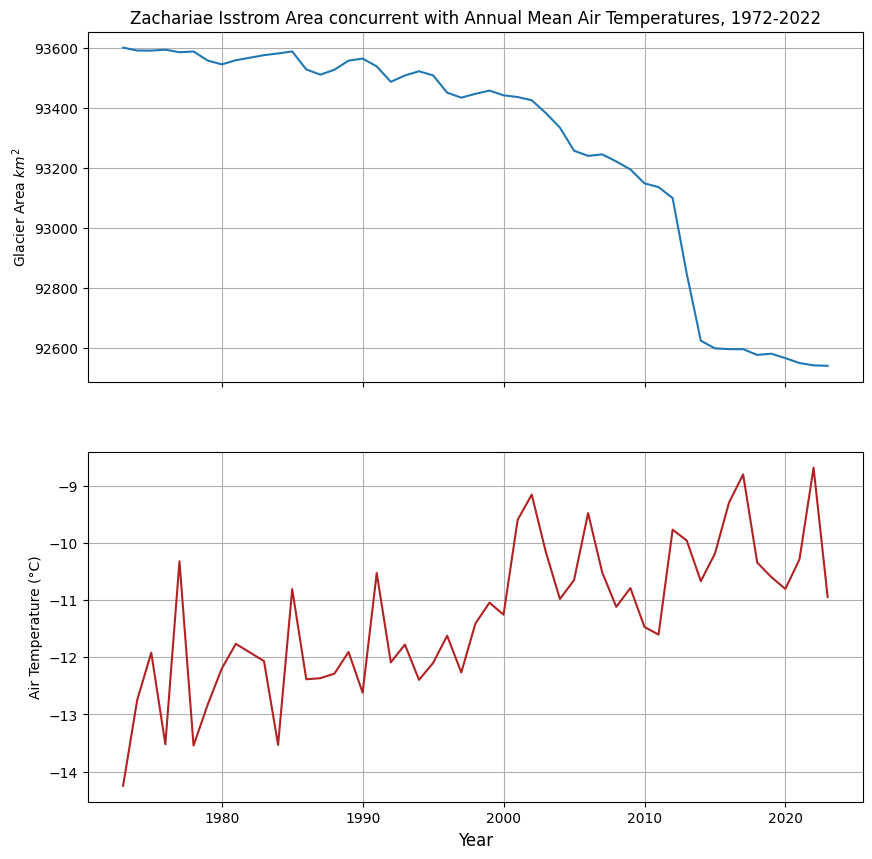

In [59]:
# plot Zachariae Isstrom area and airtemp concurrently
GLACIER = 'Zachariae Isstrom'

# get concurrent df
df = get_glacier_df(GLACIER, 'YE')

# plot and customise graph
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].set_title(f'{GLACIER} Area concurrent with Annual Mean Air Temperatures, 1972-2022')
ax[0].plot(df['area'])
ax[0].set_xticklabels([])
ax[0].set_ylabel(r'Glacier Area $km^2$')
ax[0].grid()
ax[1].plot(df['airtemp'], color='firebrick')
ax[1].set_ylabel('Air Temperature (°C)')
ax[1].set_xlabel('Year', size=12)
ax[1].grid()

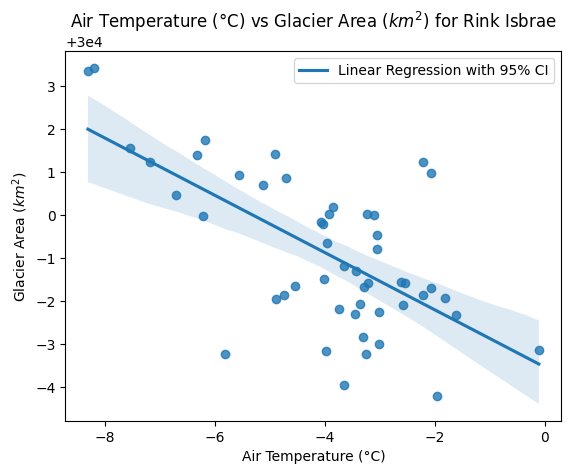

In [60]:
# plot a pairwise yearly mean scatter plot of area vs airtemp
GLACIER = 'Rink Isbrae'
SAMPLE_TIME = 'YE'
X = 'airtemp'
Y = 'area'

# set labels dict and get concurrent df
labels = {'airtemp': 'Air Temperature (°C)',
    'SST': 'Sea Surface Temperature (°C)',
    'area': r'Glacier Area ($km^2$)'}
glacier_df = get_glacier_df(GLACIER, SAMPLE_TIME)

# make regression plot with 95% confidence interval
sns.regplot(x=X, y=Y, data=glacier_df, ci=95, line_kws={'label': 'Linear Regression with 95% CI'})
plt.xlabel(labels[X])
plt.ylabel(labels[Y])
plt.title(f'{labels[X]} vs {labels[Y]} for {GLACIER}')
plt.legend()
plt.show()

# Question 3

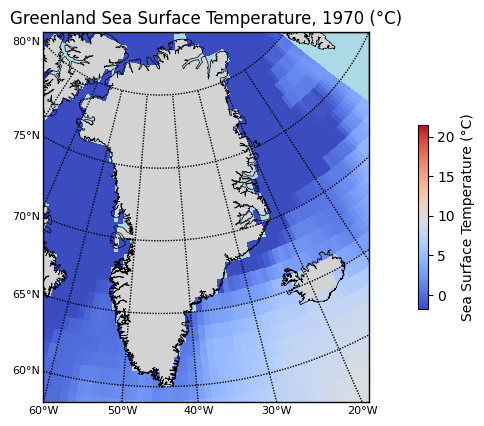

In [61]:
# map of Greenland SST, 1970
# set up map projection
m = Basemap(
    projection='lcc',  # Lambert Conformal Conic
    lat_0=70,          # Center latitude
    lon_0=-45,         # Center longitude
    lat_1=60,          # First standard parallel
    lat_2=80,          # Second standard parallel
    llcrnrlat=58,      # Lower left corner latitude
    urcrnrlat=75,      # Upper right corner latitude
    llcrnrlon=-60,     # Lower left corner longitude
    urcrnrlon=25,     # Upper right corner longitude
    resolution='i',    # Intermediate resolution
    area_thresh=1000   # Minimum area for coastlines
)

# Draw map features
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=1)
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Add gridlines
m.drawmeridians(range(-80, 0, 10), labels=[0,0,0,1], fontsize=8)
m.drawparallels(range(60, 85, 5), labels=[1,0,0,0], fontsize=8)

# get x and y from lat lon grid data
lon_grid, lat_grid = np.meshgrid(sst_lon, sst_lat)
x, y = m(lon_grid, lat_grid)

# find idx of 1970
date_idx = np.where(sst_time >= '1970-01-01')[0][0]

# get max and min for concurrent scales
vmin = min(sst[-1, :, :].min(), sst[date_idx, :, :].min())
vmax = max(sst[-1, :, :].max(), sst[date_idx, :, :].max())

# plot
plt.pcolormesh(x, y, sst[date_idx, :, :], cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.colorbar(label='Sea Surface Temperature (°C)', shrink=0.5, pad=0.1)
plt.title('Greenland Sea Surface Temperature, 1970 (°C)')
plt.show()

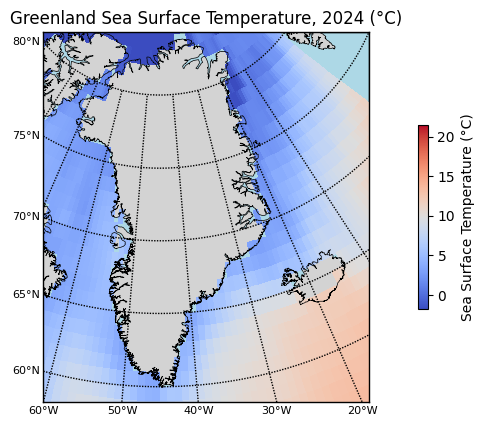

In [62]:
# map ofGreenland SST, 2024
# set up map projection
m = Basemap(
    projection='lcc',  # Lambert Conformal Conic
    lat_0=70,          # Center latitude
    lon_0=-45,         # Center longitude
    lat_1=60,          # First standard parallel
    lat_2=80,          # Second standard parallel
    llcrnrlat=58,      # Lower left corner latitude
    urcrnrlat=75,      # Upper right corner latitude
    llcrnrlon=-60,     # Lower left corner longitude
    urcrnrlon=25,     # Upper right corner longitude
    resolution='i',    # Intermediate resolution
    area_thresh=1000   # Minimum area for coastlines
)

# Draw map features
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=1)
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Add gridlines
m.drawmeridians(range(-80, 0, 10), labels=[0,0,0,1], fontsize=8)
m.drawparallels(range(60, 85, 5), labels=[1,0,0,0], fontsize=8)

# get x and y grid from lon and lat
lon_grid, lat_grid = np.meshgrid(sst_lon, sst_lat)
x, y = m(lon_grid, lat_grid)

# plot
plt.pcolormesh(x, y, sst[-1, :, :], cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.colorbar(label='Sea Surface Temperature (°C)', shrink=0.5, pad=0.1)
plt.title('Greenland Sea Surface Temperature, 2024 (°C)')
plt.show()

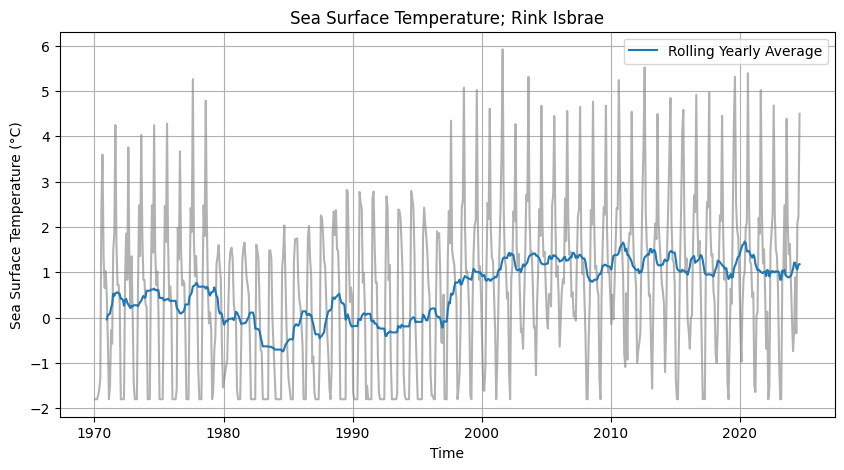

In [63]:
# sst of rink isbrae with rolling yearly average
GLACIER = 'Rink Isbrae'
START_TIME = '1970-01-01'
END_TIME = '2024-12-12'

target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])
ind_lat, ind_lon = pick_closest_SST(sst_lat, sst_lon, sst, target_location)
glacier_sst = sst[:, ind_lat, ind_lon]

restricted_time = (sst_time >= START_TIME) & (sst_time <= END_TIME)
sst_time_plot = sst_time[restricted_time]
glacier_sst_plot = glacier_sst[restricted_time]

plot_df = pd.DataFrame({'sst': glacier_sst_plot, 'date': sst_time_plot})
plot_df = plot_df.set_index('date')

plt.figure(figsize=(10,5))
plt.plot(plot_df, color='grey', alpha=0.6)
plt.plot(plot_df.rolling(window=12).mean(), label='Rolling Yearly Average')
plt.title(f'Sea Surface Temperature; {GLACIER}')
plt.xlabel('Time')
plt.ylabel('Sea Surface Temperature (°C)')
plt.grid()
plt.legend()
plt.show()

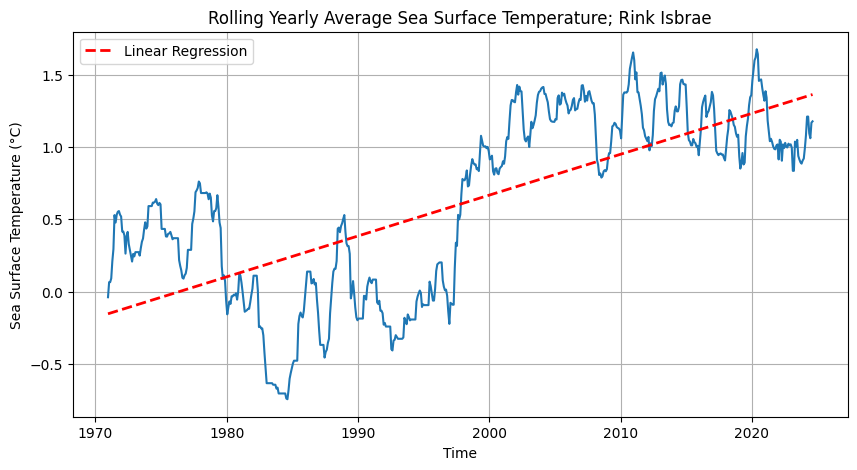

In [64]:
# rolling yearly average sst with linear regression for rink isbrae 
GLACIER = 'Rink Isbrae'
START_TIME = '1970-01-01'
END_TIME = '2024-12-12'

target_location = (glacier_locations[GLACIER]['lat'], glacier_locations[GLACIER]['lon'])
ind_lat, ind_lon = pick_closest_SST(sst_lat, sst_lon, sst, target_location)
glacier_sst = sst[:, ind_lat, ind_lon]

restricted_time = (sst_time >= START_TIME) & (sst_time <= END_TIME)
sst_time_plot = sst_time[restricted_time]
glacier_sst_plot = glacier_sst[restricted_time]

plot_df = pd.DataFrame({'sst': glacier_sst_plot, 'date': sst_time_plot})
plot_df = plot_df.set_index('date')

# find trend of rolling average
rolling_mean = plot_df.rolling(window=12).mean()
valid_data = rolling_mean.dropna()
x = np.arange(len(valid_data))
y = valid_data['sst'].values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
trend_line = p(x)

# plot and customise
plt.figure(figsize=(10,5))
plt.plot(plot_df.rolling(window=12).mean())
plt.plot(valid_data.index, trend_line, 'r--', label='Linear Regression', linewidth=2)
plt.title(f'Rolling Yearly Average Sea Surface Temperature; {GLACIER}')
plt.xlabel('Time')
plt.ylabel('Sea Surface Temperature (°C)')
plt.grid()
plt.legend()
plt.show()

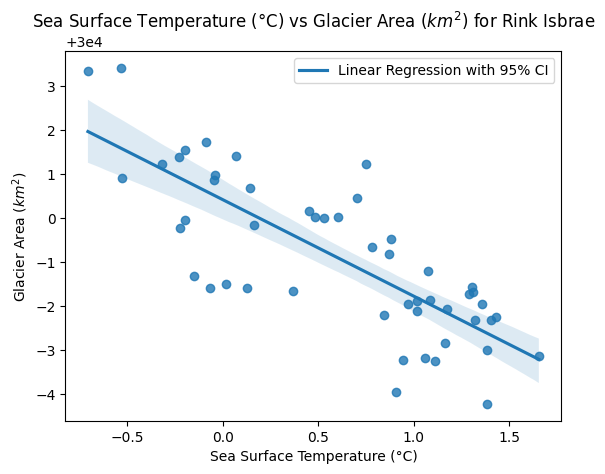

In [65]:
# plot a pairwise yearly mean scatter plot of area vs sst
GLACIER = 'Rink Isbrae'
SAMPLE_TIME = 'YE'
X = 'SST'
Y = 'area'

# set labels dict and get concurrent df
labels = {'airtemp': 'Air Temperature (°C)',
    'SST': 'Sea Surface Temperature (°C)',
    'area': r'Glacier Area ($km^2$)'}
glacier_df = get_glacier_df(GLACIER, SAMPLE_TIME)

# make regression plot with 95% confidence interval
sns.regplot(x=X, y=Y, data=glacier_df, ci=95, line_kws={'label': 'Linear Regression with 95% CI'})
plt.xlabel(labels[X])
plt.ylabel(labels[Y])
plt.title(f'{labels[X]} vs {labels[Y]} for {GLACIER}')
plt.legend()
plt.show()

# Question 4

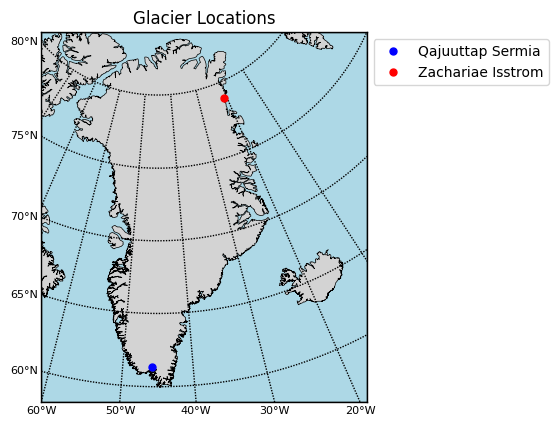

In [66]:
# set up map projection
m = Basemap(
    projection='lcc',  # Lambert Conformal Conic
    lat_0=70,          # Center latitude
    lon_0=-45,         # Center longitude
    lat_1=60,          # First standard parallel
    lat_2=80,          # Second standard parallel
    llcrnrlat=58,      # Lower left corner latitude
    urcrnrlat=75,      # Upper right corner latitude
    llcrnrlon=-60,     # Lower left corner longitude
    urcrnrlon=25,     # Upper right corner longitude
    resolution='i',    # Intermediate resolution
    area_thresh=1000   # Minimum area for coastlines
)

# Draw map features
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=1)
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Add gridlines
m.drawmeridians(range(-80, 0, 10), labels=[0,0,0,1], fontsize=8)
m.drawparallels(range(60, 85, 5), labels=[1,0,0,0], fontsize=8)

gain_glacier = 'Qajuuttap Sermia'
gain_lat = glacier_locations[gain_glacier]['lat']
gain_lon = glacier_locations[gain_glacier]['lon']
x_g, y_g = m(gain_lon, gain_lat)

loss_glacier = 'Zachariae Isstrom'
loss_lat = glacier_locations[loss_glacier]['lat']
loss_lon = glacier_locations[loss_glacier]['lon']
x_l, y_l = m(loss_lon, loss_lat)

plt.plot(x_g, y_g, marker='o', linestyle='none', color='blue', markersize=5, label=gain_glacier)
plt.plot(x_l, y_l, marker='o', linestyle='none',  color='red', markersize=5, label=loss_glacier)
plt.title('Glacier Locations')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

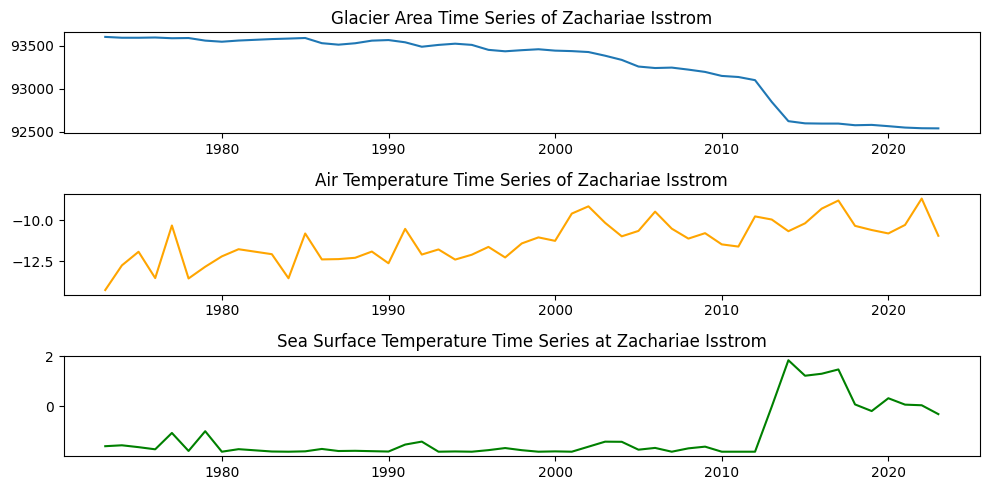

In [67]:
GLACIER = 'Zachariae Isstrom'
SAMPLE_TIME = 'YE' # Year: 'YE', 5-Year: '5YE'

glacier_df = get_glacier_df(GLACIER, SAMPLE_TIME)

fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].plot(glacier_df.index, glacier_df['area'])
ax[0].set_title(f'Glacier Area Time Series of {GLACIER}')
ax[1].plot(glacier_df.index, glacier_df['airtemp'], color='orange')
ax[1].set_title(f'Air Temperature Time Series of {GLACIER}')
ax[2].plot(glacier_df.index, glacier_df['SST'], color='green')
ax[2].set_title(f'Sea Surface Temperature Time Series at {GLACIER}')
plt.tight_layout()
plt.show()

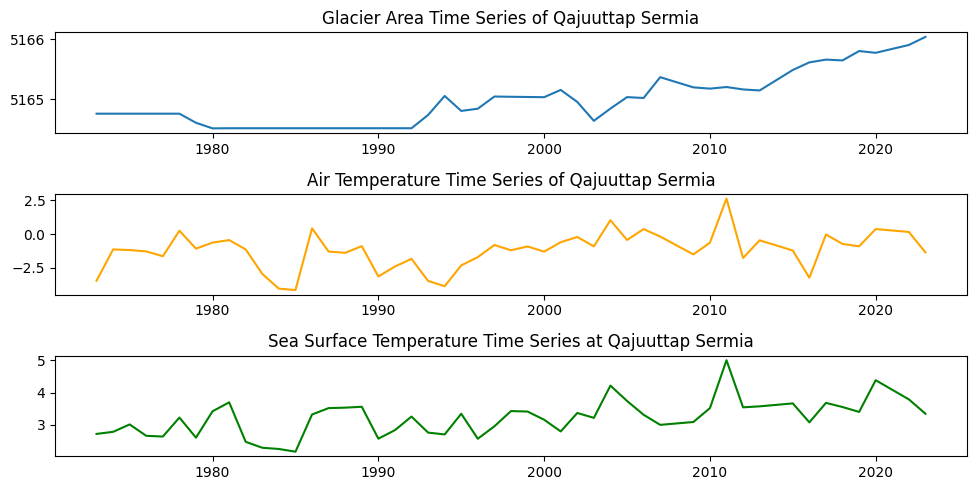

In [68]:
GLACIER = 'Qajuuttap Sermia'
SAMPLE_TIME = 'YE' # Year: 'YE', 5-Year: '5YE'

glacier_df = get_glacier_df(GLACIER, SAMPLE_TIME)

fig, ax = plt.subplots(3, 1, figsize=(10, 5))
ax[0].plot(glacier_df.index, glacier_df['area'])
ax[0].set_title(f'Glacier Area Time Series of {GLACIER}')
ax[1].plot(glacier_df.index, glacier_df['airtemp'], color='orange')
ax[1].set_title(f'Air Temperature Time Series of {GLACIER}')
ax[2].plot(glacier_df.index, glacier_df['SST'], color='green')
ax[2].set_title(f'Sea Surface Temperature Time Series at {GLACIER}')
plt.tight_layout()
plt.show()

# Question 5

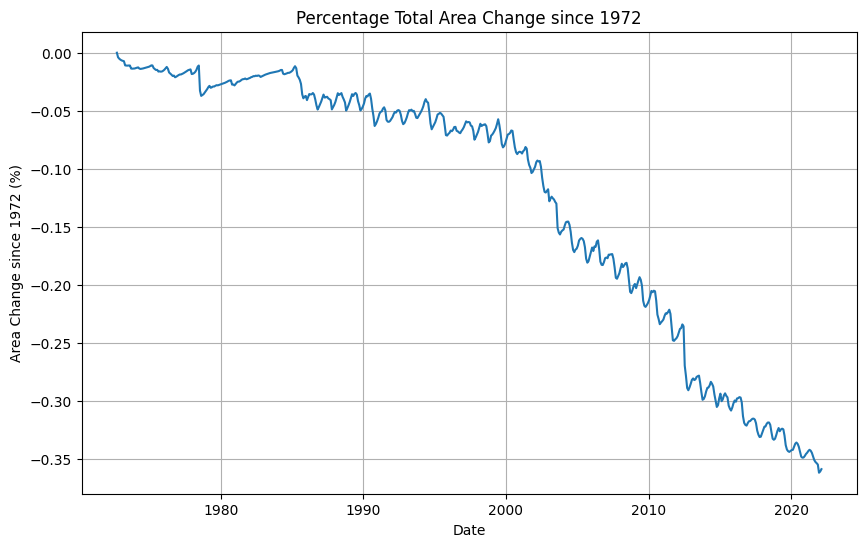

In [69]:
# calculate percentage loss
sum_areas = glacier_timeseries.sum(axis=1)
pct_loss = (sum_areas - sum_areas.iloc[0]) / sum_areas.iloc[0] * 100 # percentage

# plot percentage loss
plt.figure(figsize=(10,6))
plt.plot(pct_loss.index, pct_loss)
plt.xlabel('Date')
plt.ylabel('Area Change since 1972 (%)')
plt.title('Percentage Total Area Change since 1972')
plt.grid()
plt.show()


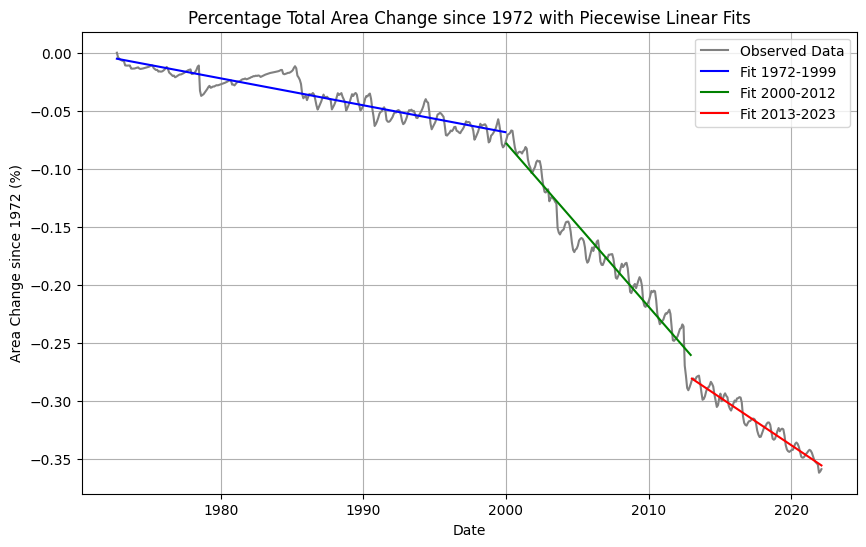

In [70]:
# split into 3 distinct sections based on visual inspection
pct_loss_1972_1999 = pct_loss[(pct_loss.index < '2000-01-01')]
pct_loss_2000_2012 = pct_loss[(pct_loss.index >= '2000-01-01') & (pct_loss.index < '2013-01-01')]
pct_loss_2013_2023 = pct_loss[pct_loss.index >= '2013-01-01']

# fit linear to each section
m1, b1 = np.polyfit(mdates.date2num(pct_loss_1972_1999.index), pct_loss_1972_1999.values, 1)
m2, b2 = np.polyfit(mdates.date2num(pct_loss_2000_2012.index), pct_loss_2000_2012.values, 1)
m3, b3 = np.polyfit(mdates.date2num(pct_loss_2013_2023.index), pct_loss_2013_2023.values, 1)

# plot each section with its fit
plt.figure(figsize=(10,6))
plt.plot(pct_loss.index, pct_loss, label='Observed Data', color='grey')
plt.plot(pct_loss_1972_1999.index, m1*mdates.date2num(pct_loss_1972_1999.index) + b1, color='blue', label='Fit 1972-1999')
plt.plot(pct_loss_2000_2012.index, m2*mdates.date2num(pct_loss_2000_2012.index) + b2, color='green', label='Fit 2000-2012')
plt.plot(pct_loss_2013_2023.index, m3*mdates.date2num(pct_loss_2013_2023.index) + b3, color='red', label='Fit 2013-2023')
plt.xlabel('Date')
plt.ylabel('Area Change since 1972 (%)')
plt.title('Percentage Total Area Change since 1972 with Piecewise Linear Fits')
plt.legend()
plt.grid()
plt.show()

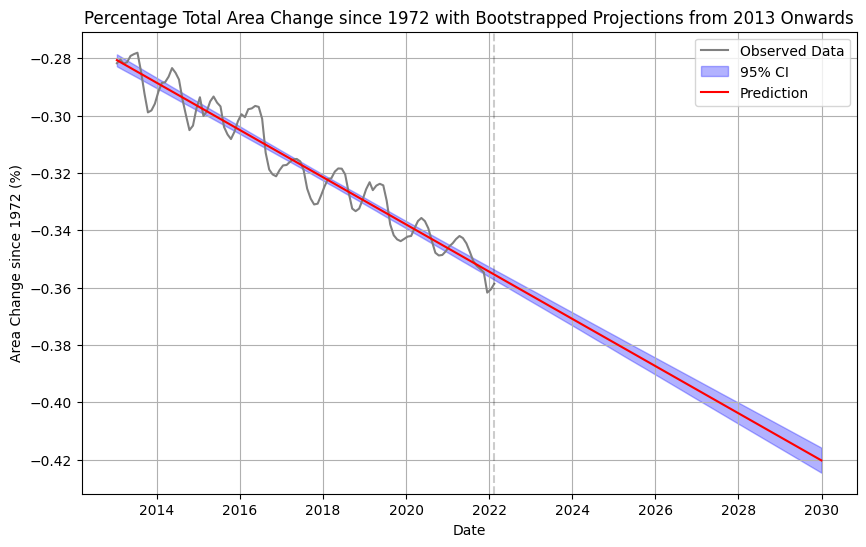

In [71]:
# 2013 onwards for future projections with bootstrap confidence intervals

# set future dates
future_dates = pd.date_range(start=pct_loss_2013_2023.index[-1], end='2030-01-01', freq='ME')
plot_dates = pct_loss_2013_2023.index.append(future_dates)

# create linear model
m, b = np.polyfit(mdates.date2num(pct_loss_2013_2023.index), pct_loss_2013_2023.values, 1)
prediction = m*mdates.date2num(plot_dates) + b

# bootstrap for model uncertainty
# draw 1000 bootstrap replicates
x = mdates.date2num(pct_loss_2013_2023.index)
y = pct_loss_2013_2023.values
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(x, y, size=1000)

# predict and get confidence intervals
bs_predictions = np.array([bs_slope_reps[i]*mdates.date2num(plot_dates) + bs_intercept_reps[i] for i in range(1000)])
ci_95 = np.percentile(bs_predictions, [2.5, 97.5], axis=0)


# plot bootstrap lines
plt.figure(figsize=(10,6))
plt.plot(pct_loss_2013_2023.index, pct_loss_2013_2023.values, label='Observed Data', color='grey')
plt.fill_between(plot_dates, ci_95[0], ci_95[1], color='blue', alpha=0.3, label='95% CI')
plt.axvline(pct_loss_2013_2023.index[-1], color='black', alpha=0.2, linestyle='--')
plt.plot(plot_dates, prediction, color='red', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Area Change since 1972 (%)')
plt.title('Percentage Total Area Change since 1972 with Bootstrapped Projections from 2013 Onwards')
plt.grid()
plt.legend()
plt.show()


In [72]:
# stats by 2030
pred_2030 = prediction[-1]
ci_2030 = ci_95[:, -1]
print(f"Area Change in {pct_loss_2013_2023.index[-1].year}: {pct_loss_2013_2023.values[-1]:.4f}%")
print(f"Projected area Change by 2030: {pred_2030:.4f}%")
print(f"95% CI for 2030: [{ci_2030[0]:.4f}%, {ci_2030[1]:.4f}%]")

Area Change in 2022: -0.3587%
Projected area Change by 2030: -0.4203%
95% CI for 2030: [-0.4245%, -0.4158%]


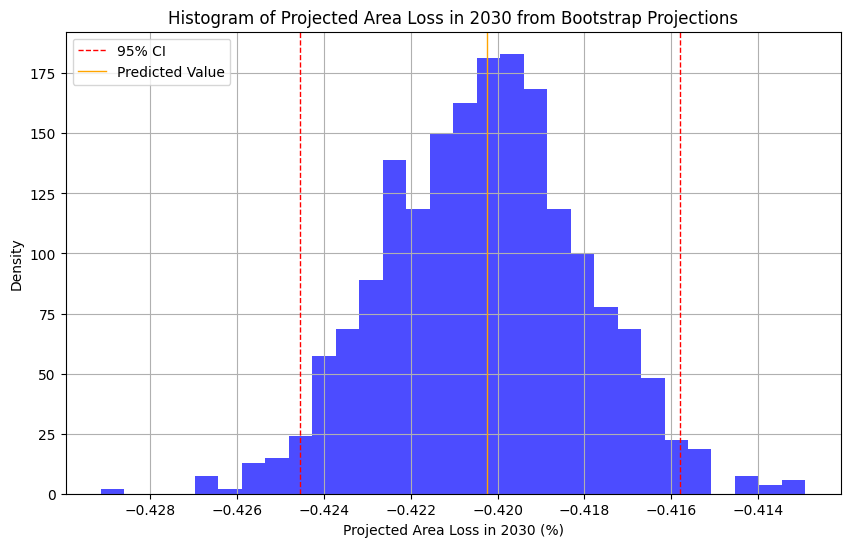

In [73]:
# histogram of area loss in 2030 from bootstrap projections with 95% CI
plt.figure(figsize=(10,6))
plt.hist(bs_predictions[:, -1], bins=30, density=True, alpha=0.7, color='blue')
plt.xlabel('Projected Area Loss in 2030 (%)')
plt.ylabel('Density')
plt.title('Histogram of Projected Area Loss in 2030 from Bootstrap Projections')
plt.axvline(ci_95[0, -1], color='red', linestyle='dashed', linewidth=1, label='95% CI')
plt.axvline(ci_95[1, -1], color='red', linestyle='dashed', linewidth=1)
plt.axvline(prediction[-1], color='Orange', linestyle='solid', linewidth=1, label='Predicted Value')
plt.grid()
plt.legend()
plt.show()

C:\Users\JoelM\AppData\Local\Temp\ipykernel_34596\3450859018.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, pd.DataFrame([new_row])], ignore_index=True)


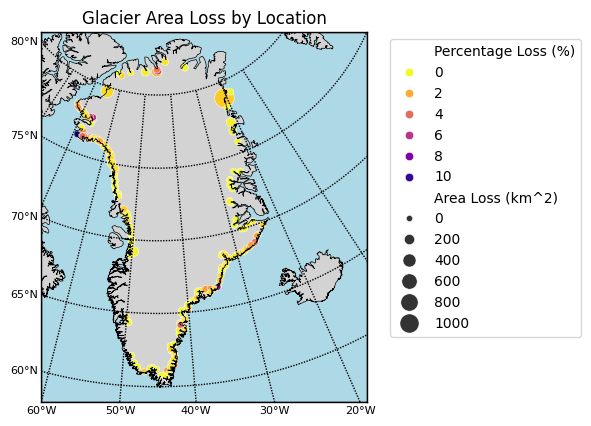

In [74]:
# set up map projection
m = Basemap(
    projection='lcc',  # Lambert Conformal Conic
    lat_0=70,          # Center latitude
    lon_0=-45,         # Center longitude
    lat_1=60,          # First standard parallel
    lat_2=80,          # Second standard parallel
    llcrnrlat=58,      # Lower left corner latitude
    urcrnrlat=75,      # Upper right corner latitude
    llcrnrlon=-60,     # Lower left corner longitude
    urcrnrlon=25,     # Upper right corner longitude
    resolution='i',    # Intermediate resolution
    area_thresh=1000   # Minimum area for coastlines
)

# Draw map features
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=1)
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Add gridlines
m.drawmeridians(range(-80, 0, 10), labels=[0,0,0,1], fontsize=8)
m.drawparallels(range(60, 85, 5), labels=[1,0,0,0], fontsize=8)

# calculate area loss for each glacier
area_change = (glacier_timeseries - glacier_timeseries.iloc[0])
area_loss = - area_change.iloc[-1]

# create a dataframe for plotting of glacier xy locations and max relative loss
plot_df = pd.DataFrame(columns=['glacier', 'x', 'y', 'loss', 'pct_loss'])
for glacier in glacier_locations:
    lat = glacier_locations[glacier]['lat']
    lon = glacier_locations[glacier]['lon']
    x, y = m(lon, lat)
    loss = area_loss[glacier]
    pct_loss = loss / glacier_timeseries[glacier].iloc[0] * 100
    new_row = {'glacier': glacier, 'x': x, 'y': y, 'loss': loss, 'pct_loss': pct_loss}
    plot_df = pd.concat([plot_df, pd.DataFrame([new_row])], ignore_index=True)

plot_df.set_index('glacier', inplace=True)

sns.scatterplot(data=plot_df, x='x', y='y', size='loss', sizes=(20,200), hue='pct_loss', palette='plasma_r', legend='brief')
plt.title('Glacier Area Loss by Location')
# customise legend
handles, labels = plt.gca().get_legend_handles_labels()
labels[0], labels[7] = ['Percentage Loss (%)', 'Area Loss (km^2)']
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', handles=handles, labels=labels)
plt.show()